In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pyod.models.ocsvm import OCSVM
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [54]:
# CONFIG
train_file = "../test_csv/normal_2.csv"
test_file = "../test_csv/motor_temp_low.csv"
sensor_tag = "rpm"
sequence_length = 1000
batch_size = 64
epochs = 50
hidden_size = 128
model_path = f"best_model_{sensor_tag}.pt"
threshold_percentile = 95

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
# Load train and test files
df = pd.read_csv(train_file, parse_dates=["timestamp"])
df_test = pd.read_csv(test_file, parse_dates=["timestamp"])

def pivot_sensor_data(df):
    pivoted = df.pivot(index="timestamp", columns="sensor", values="feature_0")
    pivoted = pivoted.interpolate().dropna()  # handle missing data
    return pivoted

X_train = pivot_sensor_data(df)
X_test = pivot_sensor_data(df_test)

# Normalize using train scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Train SVDD model
svdd = OCSVM(kernel='rbf', nu=0.05)
svdd.fit(X_train_scaled)


OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.05, shrinking=True, tol=0.001,
   verbose=False)

In [58]:
# Predict scores
scores = svdd.decision_function(X_test_scaled)

# 1. Custom threshold: 70% of max score
peak_score = np.max(scores)
threshold = 0.50 * peak_score

# 2. Custom prediction: anomaly if score < threshold
custom_pred = (scores > threshold).astype(int)  # 1 = anomaly, 0 = normal

# 3. Optional: Get true labels if available
if "is_anomaly" in df_test.columns:
    anomaly_map = df_test.groupby("timestamp")["is_anomaly"].apply(
        lambda x: int(any(str(i).lower() in ["true", "1", "yes"] for i in x))
    )

    y_true = anomaly_map.reindex(X_test.index).fillna(0).astype(int).values
else:
    y_true = None

# 4. Result DataFrame for plotting
result_df = pd.DataFrame({
    "timestamp": X_test.index,
    "score": scores,
    "custom_pred": custom_pred
})
if y_true is not None:
    result_df["true_label"] = y_true


Peak score: 54.7997
Threshold (70% of peak): 27.3999


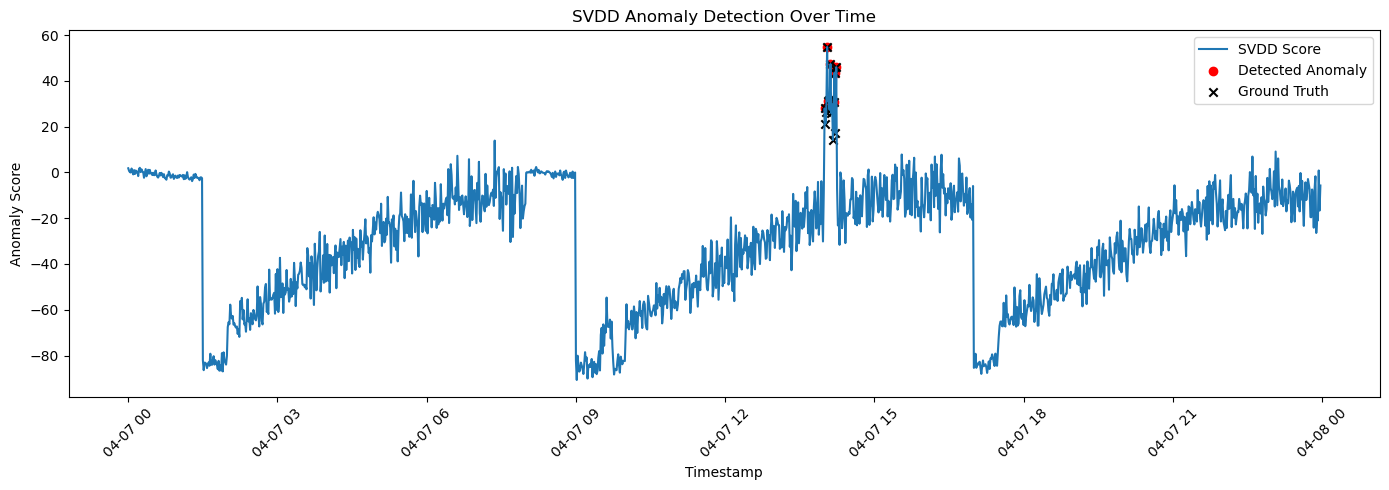

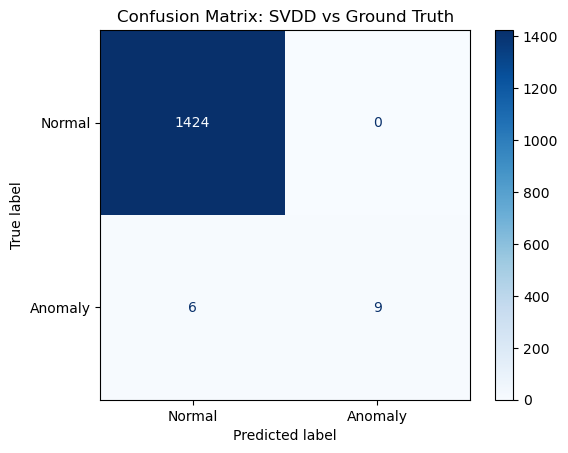

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1424
     Anomaly       1.00      0.60      0.75        15

    accuracy                           1.00      1439
   macro avg       1.00      0.80      0.87      1439
weighted avg       1.00      1.00      1.00      1439



In [62]:
print(f"Peak score: {peak_score:.4f}")
print(f"Threshold (70% of peak): {threshold:.4f}")

plt.figure(figsize=(14, 5))

# Use timestamp as x-axis
plt.plot(result_df["timestamp"], result_df["score"], label="SVDD Score")

# Detected anomalies
plt.scatter(
    result_df["timestamp"][result_df["custom_pred"] == 1],
    result_df["score"][result_df["custom_pred"] == 1],
    color='red',
    label="Detected Anomaly"
)

# Ground truth anomalies (optional)
if y_true is not None:
    plt.scatter(
        result_df["timestamp"][result_df["true_label"] == 1],
        result_df["score"][result_df["true_label"] == 1],
        marker='x',
        color='black',
        label="Ground Truth"
    )

plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.title("SVDD Anomaly Detection Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_true, custom_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: SVDD vs Ground Truth")
plt.show()

print(classification_report(y_true, custom_pred, target_names=["Normal", "Anomaly"]))